In [6]:
# 运行此段做数据准备
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

srcImg = cv.imread('../images/flower.png', 0)
rows, cols = srcImg.shape

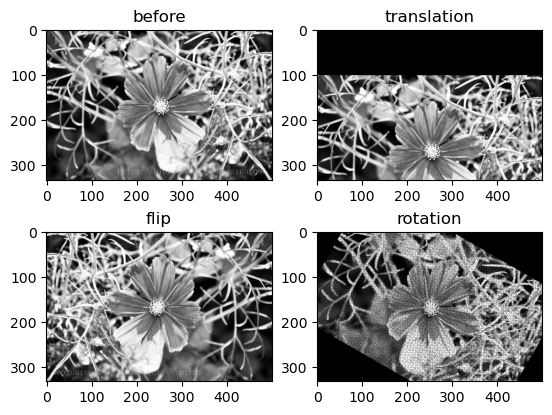

In [7]:
# 定义一个泛用的图像坐标变换的函数
#
# 参数：     1.src_img, 原图像矩阵
#           2.tran_mat, 变换矩阵
#
# 返回值：  1.new_img，进行变换后的目标图像矩阵
def img_transition(src_img, tran_mat):
    new_img = np.zeros(src_img.shape)
    rows, cols = src_img.shape
    for index, value in np.ndenumerate(src_img):
        # index_src_mat即为原始坐标向量（x,y,1）
        index_src_mat = np.array([[index[0], index[1], 1]]).T
        # index_new_mat即为目标坐标向量（x',y',1）
        index_new_mat = np.dot(tran_mat, index_src_mat)
        # 提取 x',y'到index_new_array，数据格式为数组，转化为元组index_new作为索引，运算结果可能为浮点数，所以需要做取整
        index_new_array = index_new_mat[:][:2].T.astype(np.uint)
        index_new = tuple(index_new_array.reshape(-1).tolist())
        if (index_new[0] < rows and index_new[1] < cols):
            new_img[index_new] = value
    return new_img

'''
# 原图像
'''
figure1 = plt.figure()
plt.subplot(221)
plt.title("before")
plt.imshow(srcImg, 'gray', vmin=0, vmax=255)


'''
# 平移
'''
delta_x = 100
delta_y = 0
# 创建平移矩阵，delta_x，delta_y分别表示像素向下和向右移动的距离（负值表示反向移动,即x轴正方向向下，y轴正方向向右，为笛卡尔坐标系, 也就是说x代表行(rows)，y代表列(cols))
translation_mat = np.array([[1, 0, delta_x],
                            [0, 1, delta_y],
                            [0, 0, 1]])
# 矩阵运算
img1 = img_transition(srcImg, translation_mat)
# 作图
plt.subplot(222)
plt.title("translation")
plt.imshow(img1, 'gray', vmin=0, vmax=255)


'''
# 镜像
'''
horizonal_flip = bool(True)
vertical_flip = bool(False)
# 创建镜像矩阵
if horizonal_flip == True and vertical_flip == True:
    flip_mat = np.array([[-1,  0, rows],
                         [ 0, -1, cols],
                         [ 0,  0, 1]])
elif horizonal_flip == True and vertical_flip == False:
    flip_mat = np.array([[ 1,  0, 0],
                         [ 0, -1, cols],
                         [ 0,  0, 1]])
elif horizonal_flip == False and vertical_flip == True:
    flip_mat = np.array([[-1,  0, rows],
                         [ 0,  1, 0],
                         [ 0,  0, 1]])
else:
    flip_mat = np.array([[ 1,  0, 0],
                         [ 0,  1, 0],
                         [ 0,  0, 1]])
# 矩阵运算
img2 = img_transition(srcImg, flip_mat)
# 作图        
plt.subplot(223)
plt.title("flip")
plt.imshow(img2, 'gray', vmin=0, vmax=255)


'''
# 旋转，旋转操作导致有一部分像素位置为浮点数，因而丢失了一部分像素，我们此处未进行插值处理, 图片质量不佳
'''

img3 = np.zeros(srcImg.shape)
# 以旋转30度为例，角度为正数代表顺时针旋转(旋转正方向取决于旋转矩阵)，旋转中心设置为图片中心
angle = 30
rot_center = (rows // 2, cols // 2)
# 角度转化为弧度制
rot_angle = angle / 180 * np.pi
# 创建旋转矩阵
a = np.cos(rot_angle)
b = np.sin(rot_angle)
alpha = (1 - a) * rot_center[0] - b * rot_center[1]
beta  = b * rot_center[0] + (1 - a) * rot_center[1]
rot_mat = np.array([[ a, b, alpha],
                    [-b, a, beta],
                    [ 0, 0, 1]])
# 矩阵运算
img3 = img_transition(srcImg, rot_mat)
# 作图        
plt.subplot(224)
plt.title("rotation")
plt.imshow(img3, 'gray', vmin=0, vmax=255)


下面这段为使用opencv库函数的代码,图像矩阵运算使用函数 '''cv.warpAffine()'''，输入参数应为2x3矩阵M，实际上就是略去了转移矩阵的第三行[0, 0, 1]，可参考https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

平移图像时，M就是上面代码中平移矩阵translation_mat的前两行

镜像图象时，使用'''cv.flip()'''函数，输入参数时'''flipCode'''>0表示水平翻转，=0表示垂直翻转，<0表示水平和垂直翻转

旋转图像时，使用函数'''cv.getRotationMatrix2D( center, angle, scale )'''根据输入参数旋转中心、旋转角度、放大倍数快速获取所需的转换矩阵M


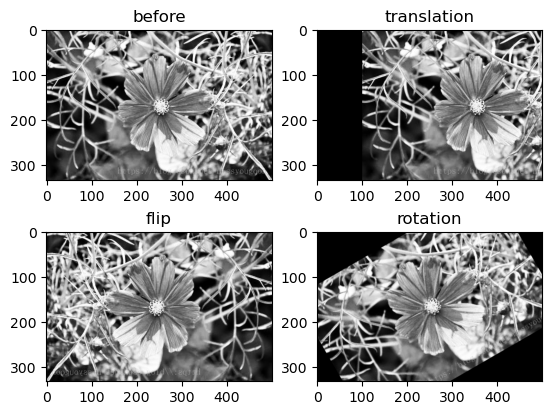

In [8]:
# 以使用opencv库函数为主
# 原图像
figure2 = plt.figure()
plt.subplot(221)
plt.title("before")
plt.imshow(srcImg, 'gray', vmin=0, vmax=255)

# 平移
delta_x = 100
delta_y = 0
# 需要注意此处变换矩阵数据类型必须为浮点型，否则会报错
warp_mat = np.float32([[1, 0, delta_x],
                       [0, 1, delta_y]])
# 此处建立的坐标系与前面相反，x轴正方向向右，y轴正方向向左，坐标系不符合右手定则，cv.warpAffine第三个参数要先输入矩阵的列(cols)作为x轴，再输入矩阵的行(rows)作为y轴
img11 = cv.warpAffine(srcImg, warp_mat, (cols, rows))
plt.subplot(222)
plt.title("translation")
plt.imshow(img11, 'gray', vmin=0, vmax=255)

# 镜像，cv.flip第二个参数为flipCode，大于0表示水平翻转，等于0表示垂直翻转，小于0则同时进行两种翻转
img12 = cv.flip(srcImg, 1)
plt.subplot(223)
plt.title("flip")
plt.imshow(img12, 'gray', vmin=0, vmax=255)

# 旋转,角度为正数代表逆时针旋转
center = (srcImg.shape[1]/2, srcImg.shape[0]/2)
angle = 30
scale = 1
rot_mat = cv.getRotationMatrix2D(center, angle, scale)
img13 = cv.warpAffine(srcImg, rot_mat, (cols, rows))
plt.subplot(224)
plt.title("rotation")
plt.imshow(img13, 'gray', vmin=0, vmax=255)


以下为学习过程中的bug记录

In [9]:
# 我们处理图像过程中的所有结果都是二元ndarray数组
# 列表和数组作为二维数组索引的效果与元组不同
# 二元素元组作为索引时可以直接输出对应的元素，即第一个元素作为行索引，第二个元素作为列索引
# 二元素列表或数组组作为索引时，不能把第二个元素识别为列索引，而是也看作行索引，所以会返回两行数据

a = np.array([[0, 1], [2, 3]])
for index, value in np.ndenumerate(a):
    # 实际上通过np.ndenumerate返回的index就是元组
    index1 = tuple(index)
    print('元组作索引', index1)
    print('索引到内容为\n', a[index1])

    index2 = list(index)
    print('列表作索引', index2)
    print('索引到内容为\n',a[index2])

    index3 = np.array(index)
    print('数组作索引', index3)
    print('索引到内容为\n',a[index3])


元组作索引 (0, 0)
索引到内容为
 0
列表作索引 [0, 0]
索引到内容为
 [[0 1]
 [0 1]]
数组作索引 [0 0]
索引到内容为
 [[0 1]
 [0 1]]
元组作索引 (0, 1)
索引到内容为
 1
列表作索引 [0, 1]
索引到内容为
 [[0 1]
 [2 3]]
数组作索引 [0 1]
索引到内容为
 [[0 1]
 [2 3]]
元组作索引 (1, 0)
索引到内容为
 2
列表作索引 [1, 0]
索引到内容为
 [[2 3]
 [0 1]]
数组作索引 [1 0]
索引到内容为
 [[2 3]
 [0 1]]
元组作索引 (1, 1)
索引到内容为
 3
列表作索引 [1, 1]
索引到内容为
 [[2 3]
 [2 3]]
数组作索引 [1 1]
索引到内容为
 [[2 3]
 [2 3]]


In [10]:
# 我们在运算过程中得到的向量仍为二维数组，将二维数组转化为二维元组容易出错，需要正确的理解数据格式
a = np.array([[0, 1], [2, 3]])
print(a)
# 直接转化不是我们想要的结果，可以看出直接转化只是把最外层数组转化为元组
print('直接转化结果为', tuple(a))
# 使用np.nditer遍历输出的每个元素仍然是数组型数据，而不是数值型
print('元素遍历', tuple(e for e in np.nditer(a)))
# 使用tolist可以正确转化为二维列表，但直接转化为元组内层元素仍然为列表,而我们希望内层元素也为元组
print('tolist间接转化结果为', tuple(a.tolist()))
# 如下方法才能到达希望的形式
result = tuple(tuple(row) for row in a)
print('正确形式', result)


[[0 1]
 [2 3]]
直接转化结果为 (array([0, 1]), array([2, 3]))
元素遍历 (array(0), array(1), array(2), array(3))
tolist间接转化结果为 ([0, 1], [2, 3])
正确形式 ((0, 1), (2, 3))
